# Create appliances individual consumption dataset

## Download files from figshare

In [5]:
import os
import requests
import re
import zipfile


In [31]:
def getFilename(cd):
    """
    Get filename from content-disposition
    """
    if not cd:
        return None
    fname = re.findall('filename=(.+)', cd)
    if len(fname) == 0:
        return None
    return fname[0].strip('"')


def downloadFile(url):
    """
    Download file from URL
    Returns file name
    """
    headers = {"Range": "bytes=0-100"}
    r = requests.get(url, allow_redirects=True, headers=headers)
    filename = getFilename(r.headers.get('content-disposition'))
    if not os.path.exists(filename):
        r = requests.get(url, allow_redirects=True)
        open(filename, 'wb').write(r.content)
    return filename


In [ ]:
urls = [
    "https://figshare.com/ndownloader/files/26179625",  # house_00
    "https://figshare.com/ndownloader/files/26179622",  # house_01
    "https://figshare.com/ndownloader/files/26179628",  # house_02
    "https://figshare.com/ndownloader/files/26179640",  # house_03
    "https://figshare.com/ndownloader/files/26179643",  # house_04
    "https://figshare.com/ndownloader/files/26179646",  # house_05
    "https://figshare.com/ndownloader/files/26179649",  # house_06
    "https://figshare.com/ndownloader/files/26179658",  # house_07
    "https://figshare.com/ndownloader/files/26179694",  # house_08
    "https://figshare.com/ndownloader/files/26179697",  # house_09
    "https://figshare.com/ndownloader/files/26179700",  # house_10
    "https://figshare.com/ndownloader/files/26179703",  # house_11
    "https://figshare.com/ndownloader/files/26179706",  # house_12
    "https://figshare.com/ndownloader/files/26179709",  # house_13
    "https://figshare.com/ndownloader/files/26179712"   # house_14
]

archives = []

for u in urls:
    archives.append(downloadFile(u))


## Parse appliances data in Pandas dataframes

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Extract data and keep only appliances with annotations

In [ ]:
folders = []

for archive in archives:
    with zipfile.ZipFile(archive, "r") as zip:
        zip.extractall()

        folder = archive.split('.')[0]

        items = pd.read_csv(os.path.join(folder, "items.tsv"), sep="\t")
        items_no = 0
        for index, item in items.iterrows():
            labels = pd.read_csv(os.path.join(
                folder, "item_{:04d}_annotation_labels.tsv".format(item.item_id)), sep="\t")
            if len(labels) > 0:
                items_no += 1
            else:
                os.remove(os.path.join(
                    folder, "item_{:04d}_data.tsv.gz".format(item.item_id)))
                os.remove(os.path.join(
                    folder, "item_{:04d}_annotation_labels.tsv".format(item.item_id)))
                os.remove(os.path.join(
                    folder, "item_{:04d}_annotations.tsv".format(item.item_id)))
        if items_no > 0:
            folders.append(folder)
        else:
            for root, dirs, files in os.walk(folder, topdown=False):
                for name in files:
                    os.remove(os.path.join(root, name))
                for name in dirs:
                    os.rmdir(os.path.join(root, name))
            os.rmdir(folder)


In [8]:
def makeDir(dirname):
    if not os.path.exists(dirname):
        os.mkdir(dirname)

In [7]:
APPLIANCES_FOLDER = "appliances"


In [ ]:
makeDir(APPLIANCES_FOLDER)

for folder in folders:
    items = pd.read_csv(os.path.join(folder, "items.tsv"), sep="\t")
    for index, item in items.iterrows():
        try:
            labels = pd.read_csv(os.path.join(
                folder, "item_{:04d}_annotation_labels.tsv".format(item.item_id)), sep="\t")
            annotations = pd.read_csv(os.path.join(
                folder, "item_{:04d}_annotations.tsv".format(item.item_id)), sep="\t", infer_datetime_format=True)
            annotations.start_date = pd.to_datetime(
                annotations.start_date, format='%Y-%m-%d %H:%M:%S')
            annotations.stop_date = pd.to_datetime(
                annotations.stop_date, format='%Y-%m-%d %H:%M:%S')
            data = pd.read_csv(os.path.join(
                folder, "item_{:04d}_data.tsv.gz".format(item.item_id)), sep="\t", compression="gzip")
            data.time = pd.to_datetime(data.time, format='%Y-%m-%d %H:%M:%S')

            makeDir(os.path.join(APPLIANCES_FOLDER, item.category))
            makeDir(os.path.join(os.path.join(APPLIANCES_FOLDER, item.category),
                                 item.label
                                 ))

            for _, label in labels.iterrows():
                makeDir(os.path.join(
                        os.path.join(
                            os.path.join(APPLIANCES_FOLDER, item.category),
                            item.label),
                        label.text
                        ))

            for _, label in labels.iterrows():
                counter = 0
                for index, annotation in annotations.iterrows():
                    if annotation.label_id == label.id:
                        df = data.loc[(data['time'] >= annotation.start_date)
                                      & (data['time'] < annotation.stop_date)]
                        df.to_csv(os.path.join(
                            os.path.join(
                                os.path.join(
                                    os.path.join(
                                        APPLIANCES_FOLDER, item.category),
                                    item.label),
                                label.text
                            ),
                            str(counter) + ".csv"
                        ))
                        counter += 1
        except Exception as e:
            continue


Remove erroneous data and unlabelled programs

In [ ]:
for root, dirs, _ in os.walk(APPLIANCES_FOLDER, topdown=False):
    for dir in dirs:
        for new_root, programs, files in os.walk(os.path.join(APPLIANCES_FOLDER, dir), topdown=False):
            try:
                lens = []
                for file in files:
                    df = pd.read_csv(os.path.join(new_root, file))
                    lens.append(len(df))
                if len(lens) == 0:
                    continue
                len_avg = np.average(lens)
                for file in files:
                    df = pd.read_csv(os.path.join(new_root, file))
                    # maximum variation admitted - 20% from the average program length to remove outliers
                    if np.abs(len_avg - len(df)) > 0.2 * len_avg:
                        os.remove(os.path.join(new_root, file))
                if len(os.listdir(new_root)) == 0:
                    os.rmdir(new_root)
            except:
                continue


In [ ]:
for root, dirs, _ in os.walk(APPLIANCES_FOLDER, topdown=False):
    for dir in dirs:
        if dir == "Error" or dir == "Unknown" or dir == "Unkown":
            for root, dirs, files in os.walk(os.path.join(root, dir), topdown=False):
                for name in files:
                    os.remove(os.path.join(root, name))
                for name in dirs:
                    os.rmdir(os.path.join(root, name))
            os.rmdir(os.path.join(root))
        if dir == "unknown activity":
            os.rename(os.path.join(root, dir), os.path.join(root, "Idle"))


Remove archives and unuseful extracted data

In [ ]:
for root, dirs, files in os.walk(".", topdown=False):
    for file in files:
        if file[:5] == "house":
            os.remove(os.path.join(root, file))
    for dir in dirs:
        if dir[:5] == "house":
            for root, dirs, files in os.walk(dir, topdown=False):
                for name in files:
                    os.remove(os.path.join(root, name))
                for name in dirs:
                    os.rmdir(os.path.join(root, name))
                os.rmdir(dir)


Trim unuseful columns

In [ ]:
for root, dirs, files in os.walk(APPLIANCES_FOLDER, topdown=False):
    for file in files:
        if file[-4:] == ".csv":
            path = os.path.join(root, file)
            df = pd.read_csv(path)
            if len(df.columns) == 4:
                df["value"].to_csv(path)


# Create consumer background consumption dataset (from non-smart appliances)

## Download files from figshare

In [ ]:
urls = [
    "https://figshare.com/ndownloader/files/28120056",  # 201901
    "https://figshare.com/ndownloader/files/28120059",  # 201902
    "https://figshare.com/ndownloader/files/28120062",  # 201903
    "https://figshare.com/ndownloader/files/28120176",  # 201904
    "https://figshare.com/ndownloader/files/28120242",  # 201905
    "https://figshare.com/ndownloader/files/28120620",  # 201906
    "https://figshare.com/ndownloader/files/28120671",  # 201907
    "https://figshare.com/ndownloader/files/28128426",  # 201908
    "https://figshare.com/ndownloader/files/28128453",  # 201909
    "https://figshare.com/ndownloader/files/28128447",  # 201910
    "https://figshare.com/ndownloader/files/28128408",  # 201911
    "https://figshare.com/ndownloader/files/28128396",  # 201912
    "https://figshare.com/ndownloader/files/28128441",  # 202001
    "https://figshare.com/ndownloader/files/28128369",  # 202002
    "",  # 202003
    "https://figshare.com/ndownloader/files/28130424",  # 202003
    "https://figshare.com/ndownloader/files/28128384",  # 202004
    "https://figshare.com/ndownloader/files/28130430",  # 202005    
]

archives = []

for u in urls:
    try:
        archives.append(downloadFile(u))
    except:
        continue


In [ ]:
BACKGROUND_FOLDER = "background"
makeDir(BACKGROUND_FOLDER)

ids_complete = []

for archive in archives:
    df = pd.read_csv(archive, compression="gzip")
    df.dropna(inplace=True)
    id_counts = df['id'].value_counts()
    ids_to_keep = id_counts[id_counts > id_counts.max() - 5].index
    df = df.loc[df['id'].isin(ids_to_keep)]
    ids_complete.append(df.id.unique())
    del df


In [ ]:
common_ids = list(set.intersection(*map(set, ids_complete)))
common_ids = np.array(common_ids, dtype=np.int64)
common_ids.sort()
print(common_ids)
print(len(common_ids))
first20 = common_ids[:20]


In [ ]:
for archive in archives:
    year = archive.split("_")[2][:4]
    year_path = os.path.join(BACKGROUND_FOLDER, year)
    makeDir(year_path)
    month = archive.split("_")[2][4:6]
    month_path = os.path.join(year_path, month)
    makeDir(month_path)
    df = pd.read_csv(archive, compression="gzip")
    df.rename(columns={df.columns[0]: 'timestamp'}, inplace=True)
    for index in range(len(first20)):
        df_filtered = df.loc[df['id'] == first20[index]]
        df_filtered.to_csv(os.path.join(month_path, str(index) + ".csv"))
    del df


In [10]:
YEARS = ["2019", "2020"]
MONTHS = ["03", "04", "05"]

In [ ]:
to_be_del = set()


for year in YEARS:
    year_path = os.path.join(BACKGROUND_FOLDER, year)
    for month in MONTHS:
        month_path = os.path.join(year_path, month)
        for index in range(20):
            df = pd.read_csv(os.path.join(month_path, str(index) + ".csv"))
            if df['value'].sum() < 50:
                to_be_del.add(index)
            else:
                df['value'] *= 1000
                df[['timestamp', 'value']].to_csv(os.path.join(month_path, str(index) + ".csv"))

for id in to_be_del:
    for year in YEARS:
        year_path = os.path.join(BACKGROUND_FOLDER, year)
        for month in MONTHS:
            month_path = os.path.join(year_path, month)
            os.remove(os.path.join(month_path, str(id) + ".csv"))

Remove archives

In [ ]:
for root, dirs, files in os.walk(".", topdown=False):
    for file in files:
        if file[:11] == "consumption":
            os.remove(os.path.join(root, file))


# Create energy production dataset from weather data

In [11]:
WEATHER_FOLDER = "weather"

makeDir(WEATHER_FOLDER)

Read API key from file smart-meter/dataset/.apikey

In [ ]:
with open(".apikey", "rt") as f:
    API_KEY = f.readline().strip()


Create temporary email using 1secmail API

In [3]:
import requests
import json
import time
import datetime
import calendar

In [ ]:
address_response = requests.get("https://www.1secmail.com/api/v1/?action=genRandomMailbox&count=1")
mail = json.loads(address_response.content)[0]
user = mail.split("@")[0]
domain = mail.split("@")[1]


Create request for data download

In [ ]:
for year in YEARS:
    url = "https://developer.nrel.gov/api/nsrdb/v2/solar/msg-iodc-download.csv?api_key=" + API_KEY + \
        "&full_name=Mihaela+Mihaiu&email=mihaela.mihaiu@mta.ro&affiliation=MTA&reason=Academic&mailing_list=false&wkt=POINT(44.57+26.06)&names=" + year + \
        "&attributes=ghi,air_temperature,surface_pressure,relative_humidity,wind_speed&leap_day=false&utc=false&interval=15"

    response = requests.get(url)

    with open(os.path.join(WEATHER_FOLDER, year + "_raw.csv"), "wb") as f:
        f.write(response.content)

    time.sleep(2)   # 2 seconds between API requests


Parse datasets

In [ ]:
for year in YEARS:
    df = pd.read_csv(os.path.join(
        WEATHER_FOLDER, year + "_raw.csv"), low_memory=False, skiprows=2)
    df['timestamp'] = pd.to_datetime(
        df[["Year", "Month", "Day", "Hour", "Minute"]])

    Rd = 287.058    # specific gas constant for dry air
    Rv = 461.495    # specific gas constant for water vapor

    df['p1'] = 6.1078 * pow(10, (7.5 * df['Temperature']) /
                            (df['Temperature'] + 273.3))
    df['pv'] = df['p1'] * df['Relative Humidity']
    df['pd'] = df['Pressure'] * 100 - df['pv']
    df['air_density'] = (df['pd'] / (Rd * (df['Temperature'] + 273.3))) + \
        (df['pv'] / (Rv * (df['Temperature'] + 273.3)))   # kg/m3
    df[["timestamp", "GHI", "air_density", "Wind Speed"]].to_csv(os.path.join(
        WEATHER_FOLDER, year + ".csv"))


In [ ]:
for year in YEARS:
    os.remove(os.path.join(
        WEATHER_FOLDER, year + "_raw.csv"))


Specify generators models

In [18]:
# https://photovoltaic-software.com/principle-ressources/how-calculate-solar-energy-power-pv-systems

SOLAR_PANELS_FOLDER = "Solar Panel"

solar_panels = {
    # https://www.europe-solarstore.com/download/lg/LG_Neon_R_Prime_LG355-370Q1K-V5_data_sheet.pdf
    "LG370Q1K-V5": {
        "area": 1.568,
        "efficiency": 0.214,
        "pr": 0.78
    },
    # https://www.europe-solarstore.com/download/sunpower/SunPower-SPR-MAX3-390_Datasheet_EN.pdf
    "SunPower SPR-MAX3-400": {
        "area": 1.659,
        "efficiency": 0.226,
        "pr": 0.75
    },
    # https://www.europe-solarstore.com/download/benq/BenQ_Sunforte_PM096B00_datasheet.pdf
    "BenQ SunForte PM096B00-335": {
        "area": 1.631,
        "efficiency": 0.196,
        "pr": 0.72
    }
}

# Power = A × r × H × PR

WIND_TURBINES_FOLDER = "Wind Turbine"

wind_turbines = {
    "AIR 40": {
        "swept_area": 1.07,
        "efficiency": 0.45
    },
    "Pikasola B08F4SYCF7": {
        "swept_area": 1.14,
        "efficiency": 0.40
    },
    "Raptor G4": {
        "swept_area": 1.70,
        "efficiency": 0.43
    }
}

# Power = 0.5 x Swept Area x Air Density x Velocity3 * efficiency


In [20]:
solar_path = os.path.join(APPLIANCES_FOLDER, SOLAR_PANELS_FOLDER)

makeDir(solar_path)

for panel in solar_panels:
    panel_path = os.path.join(solar_path, panel)
    makeDir(panel_path)

wind_path = os.path.join(APPLIANCES_FOLDER, WIND_TURBINES_FOLDER)

makeDir(wind_path)

for turbine in wind_turbines:
    turbine_path = os.path.join(wind_path, turbine)
    makeDir(turbine_path)

for year in ['2018', '2019']:
    df = pd.read_csv(os.path.join(WEATHER_FOLDER, year + ".csv"))
    for month in MONTHS:
        df['timestamp'] = pd.to_datetime(df.timestamp)
        dt = datetime.datetime(year=int(year), month=int(month), day=1)
        start = pd.to_datetime(calendar.timegm(dt.timetuple()), unit='s')
        dt = datetime.datetime(year=int(year), month=int(month)+1, day=1)
        stop = pd.to_datetime(calendar.timegm(dt.timetuple()), unit='s')
        df_month = df.loc[(df['timestamp'] >= start)
                          & (df['timestamp'] < stop)]
        days = np.unique(df_month["timestamp"].dt.date)
        for index in range(len(days) - 1):
            df_day = df_month.loc[(df_month['timestamp'] >=
                                   pd.to_datetime(days[index])) & (df_month['timestamp'] < pd.to_datetime(days[index+1]))]

            for panel in solar_panels:
                panel_path = os.path.join(solar_path, panel)
                panel_path = os.path.join(
                    panel_path, year+month+f"{index+1:02d}"+".csv")
                data = solar_panels[panel]
                values = data["area"] * data["efficiency"] * \
                    data["pr"] * df_day["GHI"]
                df_panel = pd.DataFrame(
                    data={'timestamp': df_day['timestamp'], 'value': values})
                df_panel.to_csv(panel_path)

            # for turbine in wind_turbines:
            #     turbine_path = os.path.join(wind_path, turbine)
            #     turbine_path = os.path.join(
            #         turbine_path, year+month+f"{index+1:02d}"+".csv")
            #     data = wind_turbines[turbine]
            #     values = 0.5 * data["swept_area"] * data["efficiency"] * \
            #         df_day["air_density"] * pow(df_day["Wind Speed"], 3)
            #     df_turbine = pd.DataFrame(
            #         data={'timestamp': df_day['timestamp'], 'value': values})
            #     df_turbine.to_csv(turbine_path)


In [ ]:
import pandas as pd

df = pd.read_csv("household.csv", low_memory=False)
# https://data.open-power-system-data.org/household_data/
# https://github.com/isc-konstanz/household_data/tree/2020-04-15


In [ ]:
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
df = df.set_index('utc_timestamp')


In [ ]:
df.drop(axis=1, labels=['cet_cest_timestamp', 'interpolated'], inplace=True)

In [ ]:
df = df.diff()


In [ ]:
df = df.reset_index()

In [ ]:
prefixes = []
for i in range(1, 2):
    prefixes.append("DE_KN_public" + str(i))
for i in range(1, 4):
    prefixes.append("DE_KN_industrial" + str(i))
for i in range(1, 7):
    prefixes.append("DE_KN_residential" + str(i))

groups = []

for prefix in prefixes:
    group = ["utc_timestamp"]
    for col in df.columns:
        if prefix in col:
            group.append(col)
    groups.append(group)

GRID_FOLDER = "grid"

makeDir(GRID_FOLDER)

In [ ]:
import re

min_time = None
max_time = None

for group in groups:
    df_group = df[group].dropna(subset=[x for x in group if re.search('_grid_import', x)])
    df_group['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])

    if min_time:
        if df_group['utc_timestamp'].min() > min_time:
            min_time = df_group['utc_timestamp'].min()
    else:
        min_time = df_group['utc_timestamp'].min()
    if max_time:
        if df_group['utc_timestamp'].max() < max_time:
            max_time = df_group['utc_timestamp'].max()
    else:
        max_time = df_group['utc_timestamp'].max()

print("Common range :", min_time, max_time)

Common range : 2016-05-17 10:15:00+00:00 2016-11-22 23:01:00+00:00


In [ ]:
files = []
counter = 0

for group in groups:
    df_group = df[group].dropna(
        subset=[x for x in group if re.search('_grid_import', x)])
    df_group['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
    df_group = df_group.loc[(df_group['utc_timestamp'] > min_time)
                            & (df_group['utc_timestamp'] < max_time)]
    for col in df_group.columns:
        if re.search('DE_KN_', col):
            df_group.rename(columns = {col: "_".join(col[6:].split("_")[1:])}, inplace=True)
    df_group.to_csv(os.path.join(GRID_FOLDER, prefixes[counter]) + ".csv")
    
    files.append(os.path.join(GRID_FOLDER, prefixes[counter]) + ".csv")
    counter += 1


In [ ]:
def plot_day(date):
    grid_total = None
    plt.figure(figsize=(30, 10))
    for file in files:
        d = pd.read_csv(file)
        d['utc_timestamp'] = pd.to_datetime(d['utc_timestamp'])
        d = d.set_index('utc_timestamp')
        d = d.loc[date:date]
        if "grid_export" in d.columns:
            total = d["grid_import"] - d["grid_export"]
        else:
            total = d["grid_import"]
        if grid_total is not None:
            grid_total += total
        else:
            grid_total = total
        plt.plot(total, label=file.split("_")[-1][:-4])
    plt.plot(grid_total, label="Grid total")
    plt.legend()
    plt.ylabel("Power (kW)")
    plt.xlabel("Time")
    plt.title("Power consumption in grid (All participants)")
    plt.show()
    plt.figure(figsize=(30, 5))
    for file in files[4:]:
        d = pd.read_csv(file)
        d['utc_timestamp'] = pd.to_datetime(d['utc_timestamp'])
        d = d.set_index('utc_timestamp')
        d = d.loc[date:date]
        if "grid_export" in d.columns:
            total = d["grid_import"] - d["grid_export"]
        else:
            total = d["grid_import"]
        plt.plot(total, label=file.split("_")[-1][:-4])
    plt.legend()
    plt.ylabel("Power (kW)")
    plt.xlabel("Time")
    plt.title("Power consumption in grid (Residential)")
    plt.show()
    plt.figure(figsize=(30, 5))
    d = pd.read_csv(files[5])
    d['utc_timestamp'] = pd.to_datetime(d['utc_timestamp'])
    d = d.set_index('utc_timestamp')
    d = d.loc[date:date]
    if "grid_export" in d.columns:
        d['total'] = d["grid_import"] - d["grid_export"]
    else:
        d['total'] = d["grid_import"]
    for c in d.columns[1:]:
        plt.plot(d[c], label=c)
    plt.legend()
    plt.ylabel("Power (kW)")
    plt.xlabel("Time")
    plt.title("Power consumption in Residence 1")
    plt.show()
    plt.figure(figsize=(30, 5))
    d = pd.read_csv(files[5])
    d['utc_timestamp'] = pd.to_datetime(d['utc_timestamp'])
    d = d.set_index('utc_timestamp')
    d = d.loc[date:date]
    for c in d.columns[1:]:
        if c!= "grid_import":
            plt.plot(d[c], label=c)
    plt.legend()
    plt.ylabel("Power (kW)")
    plt.xlabel("Time")
    plt.title("Power consumption in Residence 1")
    plt.show()


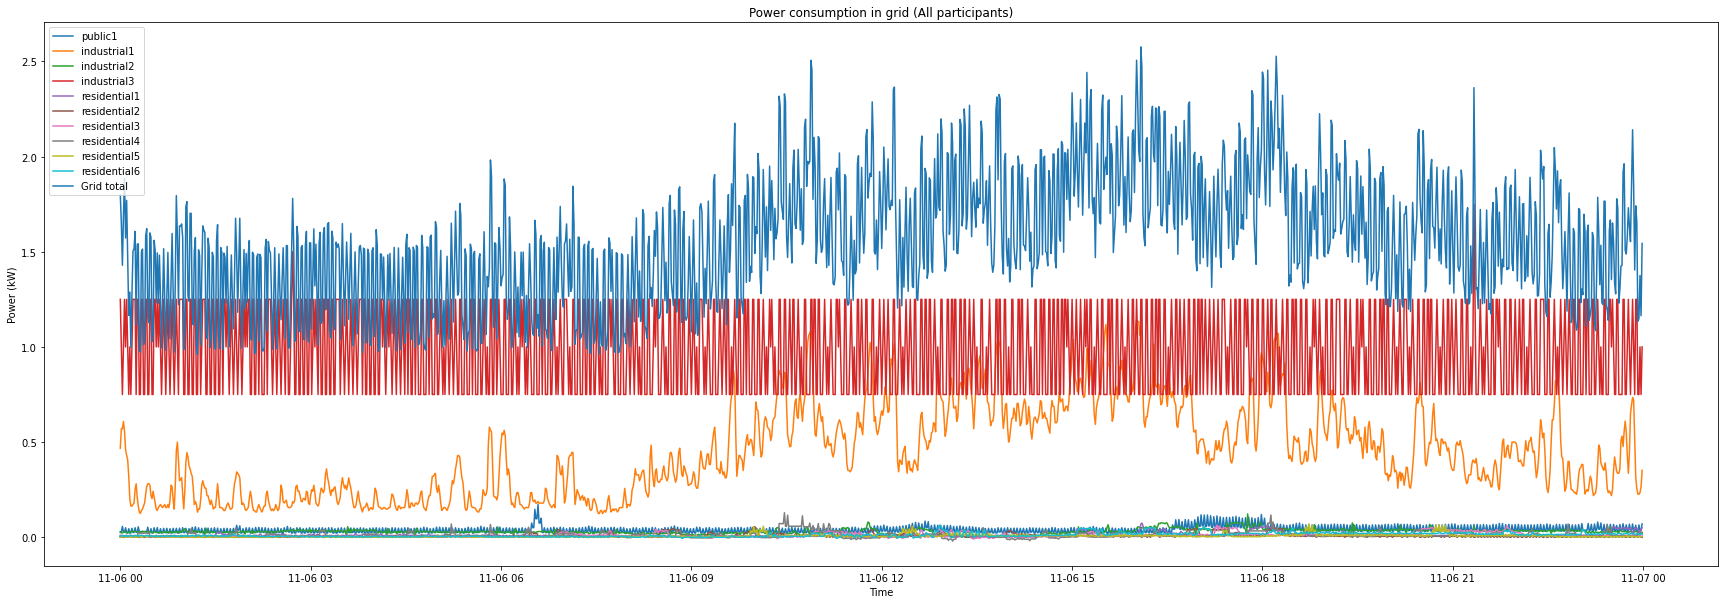

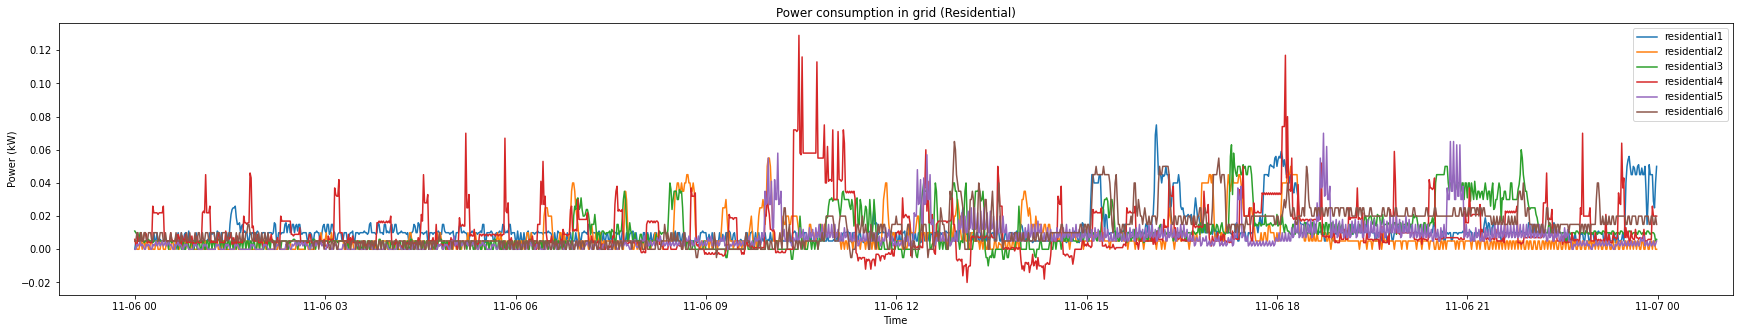

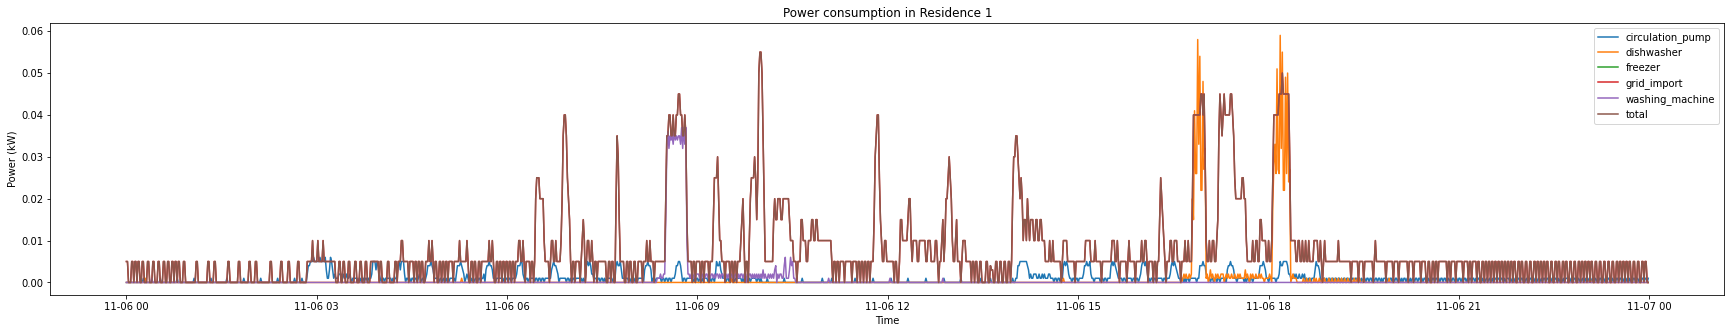

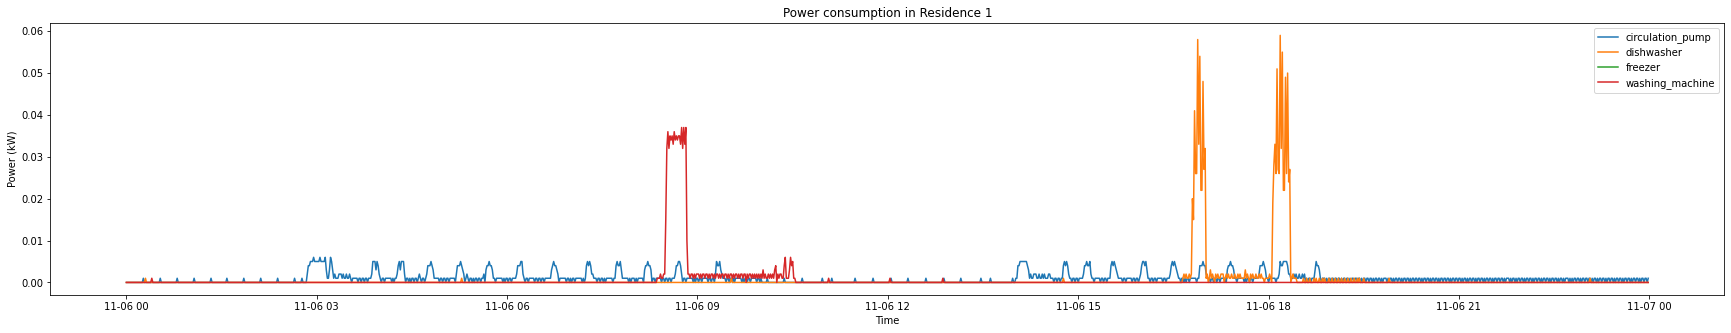

In [ ]:
plot_day('2016-11-06')


In [38]:
NON_APPLIANCES = ['grid_import', 'grid_export']
PROGRAMMABLE = ['washing_machine', 'dishwasher', 'ev']
NON_PROGRAMMABLE = ['storage_charge', 'freezer', 'area_room_3', 'area_room_4', 'machine_4', 'circulation_pump', 'compressor', 'ventilation', 'area_room_1', 'heat_pump',
                    'refrigerator', 'area_room_2', 'cooling_pumps', 'machine_5', 'machine_3', 'machine_2', 'area_offices',  'machine_1',  'cooling_aggregate']
GENERATORS = ['storage_decharge', 'pv_2', 'pv_1', 'pv', 'pv_roof', 'pv_facade']


def generate_simulation(date):
    SIMULATION_FOLDER = os.path.join(GRID_FOLDER, date)
    makeDir(SIMULATION_FOLDER)
    summ = 0

    for file in files:
        prosumer = file[11:-4]
        prosumer = os.path.join(SIMULATION_FOLDER, prosumer)
        makeDir(prosumer)
        d = pd.read_csv(file)

        d['utc_timestamp'] = pd.to_datetime(d['utc_timestamp'])
        d = d.set_index('utc_timestamp')
        d = d.loc[date:date]
        # print(d.columns, file)
        total = None
        for col in d.columns[1:]:
            if col not in NON_APPLIANCES:
                if total is None:
                    total = d[col]
                else:
                    total += d[col]
        if total is None:
            total = np.zeros(1)
        grid_consumption = d['grid_import']
        if 'grid_export' in d.columns:
            grid_consumption -= d['grid_export']
        if 'storage_charge' in d.columns:
            grid_consumption -= d['storage_charge']
        if 'storage_decharge' in d.columns:
            grid_consumption += d['storage_decharge']
        d['background'] = grid_consumption * 1000
        d['background'].to_csv(os.path.join(prosumer, "background.csv"))
        summ += d['background'].sum()
        print(file, 'sum = ', d['background'].sum() * 15 / 3600)

        for col in d.columns[1:]:
            if col in PROGRAMMABLE:
                intervals = []
                interval_start = None
                interval_end = None
                for i, value in d[col].items():
                    if value > 0.01:
                        # print(i, interval_start, interval_end)
                        if interval_start is None:
                            interval_start = i
                            interval_end = None
                        else:
                            if interval_end is None:
                                if (i - interval_start).total_seconds() < 15 * 60:
                                    interval_end = i
                                else:
                                    interval_start = i
                                    interval_end = None
                            else:
                                if (i - interval_end).total_seconds() < 15 * 60:
                                    interval_end = i
                                else:
                                    if (interval_end - interval_start).total_seconds() > 30 * 60:
                                        intervals.append(
                                            [interval_start, interval_end])
                                        print(d[col].loc[interval_start:interval_end].sum() * 15/3600)
                                    interval_start = None
                                    interval_end = None
                # print(col, intervals)
        
    print(summ)

generate_simulation('2016-11-06')


grid/DE_KN_public1.csv sum =  232.88333333333236
grid/DE_KN_industrial1.csv sum =  2691.7624999999434
grid/DE_KN_industrial2.csv sum =  174.8291666666672
grid/DE_KN_industrial3.csv sum =  5900.0
grid/DE_KN_residential1.csv sum =  69.31249999999679
0.011312499999999762
0.026975000000001883
0.01396666666666107
0.0047291666666685155
grid/DE_KN_residential2.csv sum =  44.24999999999932
grid/DE_KN_residential3.csv sum =  64.07916666666604
grid/DE_KN_residential4.csv sum =  68.55833333333389
0.0021625000000001253
0.04552499999999732
grid/DE_KN_residential5.csv sum =  40.72083333333367
grid/DE_KN_residential6.csv sum =  72.16666666666619
2246054.9999999856


In [ ]:
generate_simulation('2017-04-02')

dishwasher []
ev []
dishwasher []
washing_machine []
dishwasher []
washing_machine []
dishwasher []
washing_machine []
dishwasher []
ev []
washing_machine []
dishwasher []
washing_machine []
dishwasher []
washing_machine []


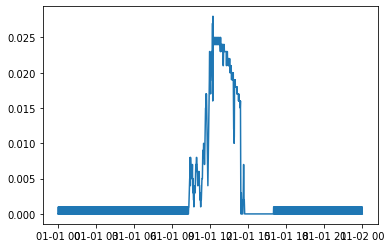

In [ ]:
plt.plot(d['DE_KN_industrial2_storage_charge'].loc['2017-01-01':'2017-01-01'])
plt.plot(d['DE_KN_industrial2_storage_decharge'].loc['2017-01-01':'2017-01-01'])

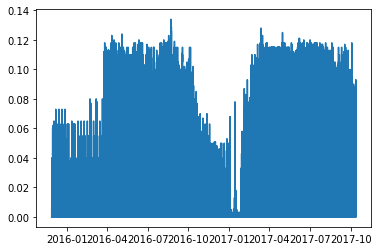

In [ ]:
plt.plot(d['DE_KN_industrial1_pv_1'])


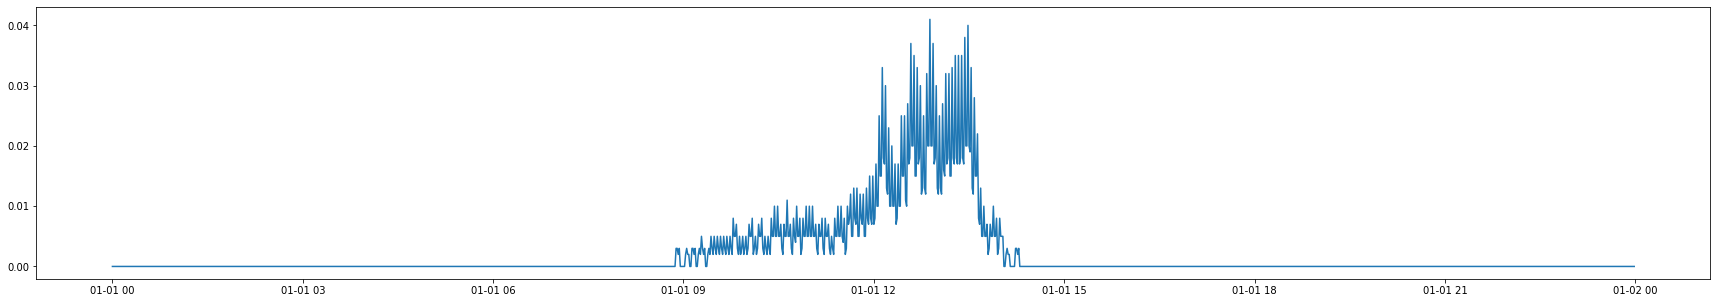

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(d['DE_KN_industrial1_pv_2'].loc['2017-01-01':'2017-01-01'])


In [ ]:
df['total_grid_import'] = df[['DE_KN_industrial1_grid_import',
                              'DE_KN_industrial2_grid_import',
                              'DE_KN_industrial3_grid_import',
                              'DE_KN_public1_grid_import',
                              'DE_KN_public2_grid_import',
                              'DE_KN_residential1_grid_import',
                              'DE_KN_residential2_grid_import',
                              'DE_KN_residential3_grid_import',
                              'DE_KN_residential4_grid_import',
                              'DE_KN_residential5_grid_import',
                              'DE_KN_residential6_grid_import']].sum(axis=1)


In [ ]:
df['total_grid_import'] = df[['DE_KN_residential3_grid_import',
                              'DE_KN_residential4_grid_import',
                              'DE_KN_residential6_grid_import']].sum(axis=1)


In [ ]:
df['total_grid_export'] = df[['DE_KN_residential3_grid_export',
                              'DE_KN_residential4_grid_export',
                              'DE_KN_residential6_grid_export']].sum(axis=1)

In [ ]:
df['balance'] = df['total_grid_import'] - df['total_grid_export']


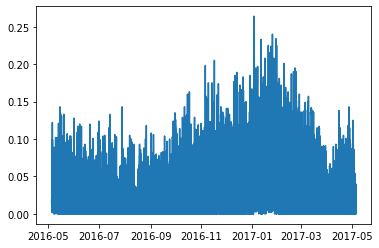

In [ ]:
plt.plot(df['total_grid_import'].loc['2016-05-05':'2017-05-05'])


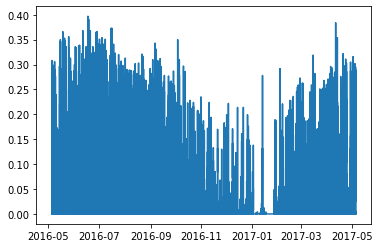

In [ ]:
plt.plot(df['total_grid_export'].loc['2016-05-05':'2017-05-05'])


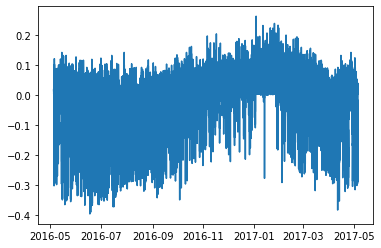

In [ ]:
plt.plot(df['balance'].loc['2016-05-05':'2017-05-05'])


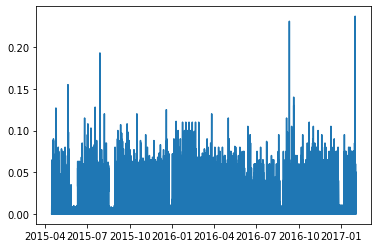

In [ ]:
plt.plot(df['DE_KN_residential2_grid_import'])

In [ ]:
df['DE_KN_residential2_grid_import'].dropna(how='any').to_csv("export.csv")

In [ ]:
s = df['DE_KN_residential2_grid_import'].loc['2015-10-05':'2016-10-05']

In [ ]:
s = pd.DataFrame(s)

In [ ]:
s = s.reset_index()

In [ ]:
s.rename(columns={'utc_timestamp': 'ds', 'DE_KN_residential2_grid_import': 'y'}, inplace=True)

In [ ]:
s['ds'] = s['ds'].dt.tz_localize(None)


In [ ]:
s['ds'].min()

Timestamp('2015-10-05 00:00:00')

In [ ]:
import prophet


In [ ]:
m = prophet.Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=10.0).fit(s)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


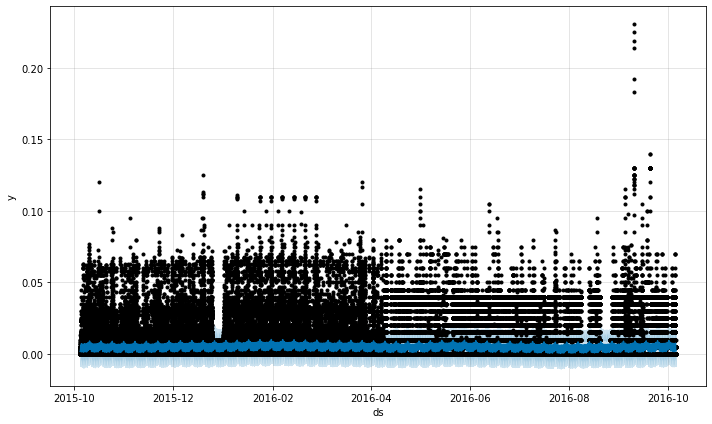

In [ ]:
future = m.make_future_dataframe(periods=1, freq='1min')
fcst = m.predict(future)
fig = m.plot(fcst)

In [ ]:
y_true = df['DE_KN_residential2_grid_import'].loc['2016-10-05':'2016-10-06'].values

In [ ]:
y_hat = fcst['yhat'][-2880:].values

In [ ]:
y_true

array([0.005, 0.005, 0.   , ..., 0.005, 0.005, 0.   ])

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
week_ago = df['DE_KN_residential2_grid_import'].loc['2016-09-28':'2016-09-29'].values
two_week_ago = df['DE_KN_residential2_grid_import'].loc['2016-09-21':'2016-09-22'].values
three_week_ago = df['DE_KN_residential2_grid_import'].loc['2016-09-14':'2016-09-15'].values
four_week_ago = df['DE_KN_residential2_grid_import'].loc['2016-09-07':'2016-09-08'].values
last_year = df['DE_KN_residential2_grid_import'].loc['2015-10-07':'2015-10-08'].values


In [ ]:
def f(y_true, y_hat):
    mae = mean_absolute_error(y_true, y_hat)
    print('MAE: %.5f' % mae)
    # plot expected vs actual
    plt.plot(y_true, label='Actual')
    plt.plot(y_hat, label='Predicted')
    plt.legend()
    plt.show()

MAE: 0.00478


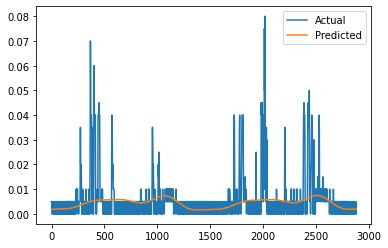

In [ ]:
f(y_true, y_hat)
# 0.00478

MAE: 0.00638


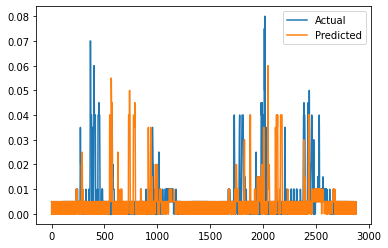

In [ ]:
f(y_true, week_ago)

MAE: 0.00540


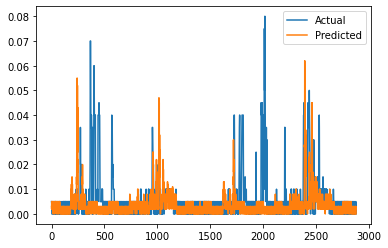

In [ ]:
f(y_true, last_year)


MAE: 0.00565


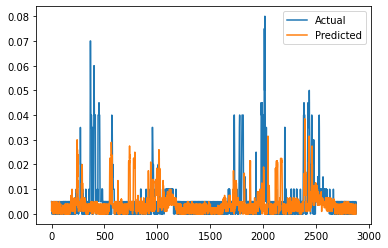

In [ ]:
f(y_true, np.average([week_ago, last_year], axis=0))


MAE: 0.00566


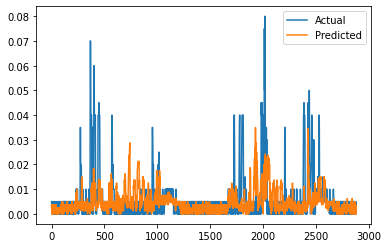

In [ ]:
f(y_true, np.average([week_ago, two_week_ago, three_week_ago, four_week_ago], axis=0))


In [ ]:
import itertools
import numpy as np
import pandas as pd

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v))
              for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

cutoffs = pd.to_datetime(['2015-10-15',
                          '2015-11-15',
                          '2015-12-15',
                          '2016-01-15',
                          '2016-02-15',
                          '2016-03-15',
                          '2016-04-15',
                          '2016-05-15',
                          '2016-06-15',
                          '2016-07-15',
                          '2016-08-15',
                          '2016-09-15'])

# Use cross validation to evaluate all parameters
for params in all_params:
    model = prophet.Prophet(**params).fit(s)  # Fit model with given params
    df_cv = prophet.diagnostics.cross_validation(model, cutoffs=cutoffs,
                             horizon='7 days', parallel="processes")
    df_p = prophet.diagnostics.performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print(best_params)

# {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}


INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INF

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  0.007902
1                     0.001                     0.10  0.007902
2                     0.001                     1.00  0.007902
3                     0.001                    10.00  0.007902
4                     0.010                     0.01  0.007901
5                     0.010                     0.10  0.007901
6                     0.010                     1.00  0.007901
7                     0.010                    10.00  0.007901
8                     0.100                     0.01  0.007902
9                     0.100                     0.10  0.009208
10                    0.100                     1.00  0.011696
11                    0.100                    10.00  0.009835
12                    0.500                     0.01  0.007908
13                    0.500                     0.10  0.009051
14                    0.500                     1.00  0